# Sub-graphs with Claude: Healthcare Patient Intake System

## Overview

This notebook demonstrates multi-agent healthcare workflows using LangGraph sub-graphs with Claude.

## What This System Does

A **multi-agent patient triage system** that:

1. **Accepts patient intake forms** (symptoms, vital signs, urgency scores)
2. **Validates and normalizes data** 
3. **Runs two parallel analyses:**
   - **Urgent Case Detection**: Identifies high-priority cases needing immediate attention
   - **Symptom Pattern Analysis**: Analyzes trends across all patients

## Sub-graph Communication

- Sub-graphs READ `cleaned_intakes` from parent
- Parent READS `urgent_summary` and `pattern_report` from sub-graphs
- Both WRITE to `processed_patients` (accumulated)

Perfect for healthcare systems where specialists handle different triage aspects.

In [8]:
%%capture --no-stderr
%pip install -U langgraph anthropic

In [9]:
from dotenv import load_dotenv
load_dotenv('studio/.env')

True

In [10]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

# Patient intake form structure
class PatientIntake(TypedDict):
    patient_id: str
    name: str
    age: int
    symptoms: List[str]
    vital_signs: Optional[dict]  # e.g., {"bp": "140/90", "temp": "101.2", "hr": "95"}
    urgency_score: Optional[int]  # 1-10, where 10 is most urgent
    chief_complaint: str
    medical_history: Optional[List[str]]

## Urgent Case Detection Sub-graph

Identifies patients requiring immediate medical attention.

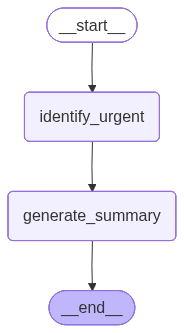

In [11]:
from anthropic import Anthropic
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

client = Anthropic()

# Urgent Case Detection State
class UrgentCaseState(TypedDict):
    cleaned_intakes: List[PatientIntake]
    urgent_cases: List[PatientIntake]
    urgent_summary: str
    processed_patients: List[str]

class UrgentCaseOutputState(TypedDict):
    urgent_summary: str
    processed_patients: List[str]

def identify_urgent_cases(state):
    """Filter patients with high urgency scores (8+)"""
    cleaned_intakes = state["cleaned_intakes"]
    urgent_cases = [
        intake for intake in cleaned_intakes 
        if intake.get("urgency_score", 0) >= 8
    ]
    return {"urgent_cases": urgent_cases}

def generate_urgent_summary(state):
    """Generate triage summary using Claude"""
    urgent_cases = state["urgent_cases"]
    
    if not urgent_cases:
        return {
            "urgent_summary": "No urgent cases detected.",
            "processed_patients": []
        }
    
    cases_text = "\n\n".join([
        f"Patient ID: {c['patient_id']}\n"
        f"Name: {c['name']}, Age: {c['age']}\n"
        f"Chief Complaint: {c['chief_complaint']}\n"
        f"Symptoms: {', '.join(c['symptoms'])}\n"
        f"Urgency Score: {c['urgency_score']}/10\n"
        f"Vitals: {c.get('vital_signs', 'Not recorded')}"
        for c in urgent_cases
    ])
    
    prompt = f"""You are an ER triage nurse. Review these urgent cases and provide:
1. Immediate action recommendations
2. Priority ordering (most to least urgent)
3. Any red flags requiring specialist consultation

URGENT CASES:
{cases_text}

Provide a clear, actionable triage summary."""
    
    message = client.messages.create(
        model="claude-haiku-4-5-20251001",
        max_tokens=800,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return {
        "urgent_summary": message.content[0].text,
        "processed_patients": [f"urgent-triage-{c['patient_id']}" for c in urgent_cases]
    }

# Build Urgent Case Detection sub-graph
urgent_builder = StateGraph(
    state_schema=UrgentCaseState,
    output_schema=UrgentCaseOutputState
)
urgent_builder.add_node("identify_urgent", identify_urgent_cases)
urgent_builder.add_node("generate_summary", generate_urgent_summary)
urgent_builder.add_edge(START, "identify_urgent")
urgent_builder.add_edge("identify_urgent", "generate_summary")
urgent_builder.add_edge("generate_summary", END)

urgent_graph = urgent_builder.compile()
display(Image(urgent_graph.get_graph().draw_mermaid_png()))

## Symptom Pattern Analysis Sub-graph

Analyzes symptom trends across all patients for epidemiological insights.

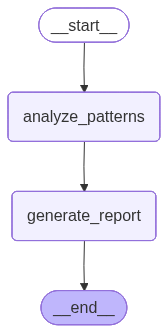

In [12]:
# Symptom Pattern Analysis State
class SymptomPatternState(TypedDict):
    cleaned_intakes: List[PatientIntake]
    pattern_analysis: str
    pattern_report: str
    processed_patients: List[str]

class SymptomPatternOutputState(TypedDict):
    pattern_report: str
    processed_patients: List[str]

def analyze_symptom_patterns(state):
    """Analyze symptom patterns using Claude"""
    cleaned_intakes = state["cleaned_intakes"]
    
    # Aggregate all symptoms
    all_symptoms = []
    for intake in cleaned_intakes:
        all_symptoms.extend(intake['symptoms'])
    
    patients_text = "\n".join([
        f"Patient {i['patient_id']}: {', '.join(i['symptoms'])} (Age: {i['age']})"
        for i in cleaned_intakes
    ])
    
    prompt = f"""You are an epidemiologist analyzing patient intake data. Identify:
1. Common symptom patterns
2. Potential disease clusters or outbreaks
3. Age group correlations
4. Recommendations for public health monitoring

PATIENT DATA:
{patients_text}

Provide epidemiological insights."""
    
    message = client.messages.create(
        model="claude-haiku-4-5-20251001",
        max_tokens=600,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return {
        "pattern_analysis": message.content[0].text,
        "processed_patients": [f"pattern-analysis-{i['patient_id']}" for i in cleaned_intakes]
    }

def generate_report(state):
    """Format report for clinical staff"""
    pattern_analysis = state["pattern_analysis"]
    
    report = f"""📊 SYMPTOM PATTERN REPORT
{'=' * 50}

{pattern_analysis}

{'=' * 50}
Report generated for clinical review and public health monitoring."""
    
    return {"pattern_report": report}

# Build Symptom Pattern sub-graph
pattern_builder = StateGraph(
    SymptomPatternState,
    output_schema=SymptomPatternOutputState
)
pattern_builder.add_node("analyze_patterns", analyze_symptom_patterns)
pattern_builder.add_node("generate_report", generate_report)
pattern_builder.add_edge(START, "analyze_patterns")
pattern_builder.add_edge("analyze_patterns", "generate_report")
pattern_builder.add_edge("generate_report", END)

pattern_graph = pattern_builder.compile()
display(Image(pattern_graph.get_graph().draw_mermaid_png()))

## Main Entry Graph

Orchestrates both sub-graphs:
- `processed_patients` accumulates from BOTH sub-graphs
- Sub-graphs run in parallel
- Communication via overlapping state keys

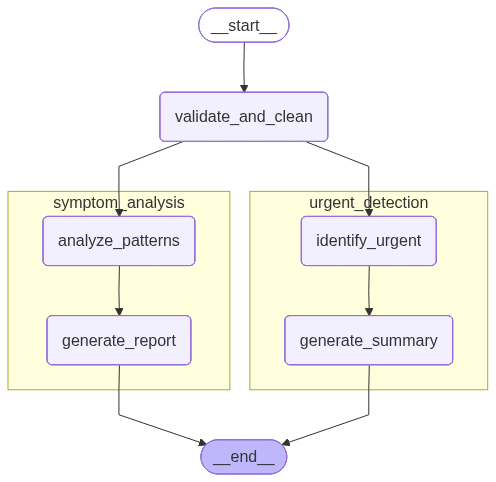

In [13]:
# Entry Graph State
class EntryGraphState(TypedDict):
    raw_intakes: List[PatientIntake]
    cleaned_intakes: List[PatientIntake]
    urgent_summary: str
    pattern_report: str
    processed_patients: Annotated[List[str], add]

def validate_and_clean(state):
    """Validate and normalize patient intake data"""
    raw_intakes = state["raw_intakes"]
    
    # In production: validate formats, normalize data, check for duplicates
    cleaned_intakes = raw_intakes
    
    return {"cleaned_intakes": cleaned_intakes}

# Build entry graph
entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("validate_and_clean", validate_and_clean)
entry_builder.add_node("urgent_detection", urgent_builder.compile())
entry_builder.add_node("symptom_analysis", pattern_builder.compile())

# Flow: START -> validate -> (urgent + symptom analysis in parallel) -> END
entry_builder.add_edge(START, "validate_and_clean")
entry_builder.add_edge("validate_and_clean", "urgent_detection")
entry_builder.add_edge("validate_and_clean", "symptom_analysis")
entry_builder.add_edge("urgent_detection", END)
entry_builder.add_edge("symptom_analysis", END)

graph = entry_builder.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Test with Sample Patients

In [14]:
# Sample patient intakes
patients = [
    PatientIntake(
        patient_id="P001",
        name="Sarah Johnson",
        age=67,
        symptoms=["severe chest pain", "shortness of breath", "nausea", "sweating"],
        vital_signs={"bp": "180/110", "hr": "105", "temp": "98.6", "o2_sat": "92%"},
        urgency_score=10,
        chief_complaint="Crushing chest pain for 30 minutes",
        medical_history=["hypertension", "diabetes", "high cholesterol"]
    ),
    PatientIntake(
        patient_id="P002",
        name="Michael Chen",
        age=34,
        symptoms=["fever", "cough", "fatigue", "body aches"],
        vital_signs={"temp": "101.8", "hr": "88", "bp": "120/80"},
        urgency_score=4,
        chief_complaint="Flu-like symptoms for 3 days",
        medical_history=[]
    ),
    PatientIntake(
        patient_id="P003",
        name="Emily Rodriguez",
        age=28,
        symptoms=["severe headache", "stiff neck", "sensitivity to light", "fever"],
        vital_signs={"temp": "103.2", "hr": "110", "bp": "115/75"},
        urgency_score=9,
        chief_complaint="Worst headache of my life, neck stiffness",
        medical_history=[]
    ),
    PatientIntake(
        patient_id="P004",
        name="James Wilson",
        age=45,
        symptoms=["cough", "fever", "fatigue"],
        vital_signs={"temp": "100.9", "hr": "82"},
        urgency_score=3,
        chief_complaint="Cold symptoms",
        medical_history=["asthma"]
    ),
    PatientIntake(
        patient_id="P005",
        name="Lisa Martinez",
        age=52,
        symptoms=["abdominal pain", "vomiting", "fever"],
        vital_signs={"temp": "102.1", "hr": "98", "bp": "135/85"},
        urgency_score=7,
        chief_complaint="Severe right lower abdominal pain",
        medical_history=[]
    )
]

# Run the triage system
result = graph.invoke({"raw_intakes": patients})

# Display results
print("\n" + "=" * 70)
print("🚨 URGENT CASE TRIAGE SUMMARY")
print("=" * 70)
print(result.get("urgent_summary", "No urgent cases"))

print("\n" + "=" * 70)
print("📊 SYMPTOM PATTERN ANALYSIS")
print("=" * 70)
print(result.get("pattern_report", "No patterns detected"))

print("\n" + "=" * 70)
print("✅ PROCESSED PATIENTS")
print("=" * 70)
for patient_id in result.get("processed_patients", []):
    print(f"  • {patient_id}")


🚨 URGENT CASE TRIAGE SUMMARY
# ER TRIAGE SUMMARY & RECOMMENDATIONS

## PRIORITY RANKING

### 🔴 **PRIORITY 1 - P001 (Sarah Johnson, 67F)**
**Condition: Acute Coronary Syndrome (ACS) - CRITICAL**

**Immediate Actions:**
- **Activate Code STEMI protocol immediately**
- Place on continuous cardiac monitoring (12-lead ECG within 2 minutes)
- Establish IV access (2 large-bore lines)
- Administer oxygen to maintain SpO2 >94%
- STAT troponin, CBC, CMP, coagulation studies
- Aspirin 325mg (if not contraindicated)
- Nitroglycerin protocol per cardiology standing orders
- Have crash cart at bedside
- Notify cardiology/interventional cardiology STAT
- Prepare for possible cardiac catheterization

**Red Flags Present:**
- Classic ACS presentation (age, crushing chest pain, diaphoresis, nausea)
- Hypertensive urgency (180/110)
- Hypoxia (92%)
- Tachycardia (105)
- 30-minute symptom duration = critical intervention window

---

### 🟠 **PRIORITY 2 - P003 (Emily Rodriguez, 28F)**
**Condition: Meningit

## Summary

This healthcare triage system demonstrates:

1. **Sub-graphs**: Separate workflows for urgent detection and pattern analysis
2. **Parallel execution**: Both analyses run simultaneously
3. **State communication**: Via overlapping keys
4. **State accumulation**: `processed_patients` collects from both sub-graphs
5. **Claude AI**: Clinical insights from `claude-haiku-4-5-20251001`

Real-world applications:
- Emergency department triage
- Telemedicine intake screening
- Public health surveillance
- Clinical decision support